# Denoising Diffusion Probabilistic Model in 1 Dimension

In [1]:
# !pip install seaborn

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from numpy import random
import random as rd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Create a biomodal dataset

In [3]:
from torch.distributions import Categorical, Normal, MultivariateNormal
from typing import List


def sample_gmm_1d(means: List[float], stddevs: List[float], mixing_coefficients: List[float], N: int = 1000):
    assert len(means) == len(stddevs) == len(mixing_coefficients)
    assert sum(mixing_coefficients) == 1

    cat = Categorical(torch.tensor(mixing_coefficients))
    norms = [Normal(means[comp], stddevs[comp]) for comp in range(len(means))]
    
    return torch.cat([
        norms[cat.sample()].sample().unsqueeze(0).unsqueeze(0)
        for _ in range(N)
    ])


def sample_gmm_2d(means: List[List[float]], scales: List[float], mixing_coefficients: List[float], N: int = 1000):
    assert len(means) == len(scales) == len(mixing_coefficients)
    assert all(len(mean) == 2 for mean in means)
    assert sum(mixing_coefficients) == 1

    means = [torch.tensor(mean) for mean in means]
    scale_trils = [torch.diag(scale * torch.ones(2,)) for scale in scales]

    cat = Categorical(torch.tensor(mixing_coefficients))
    mvns = [MultivariateNormal(means[comp], scale_tril=scale_trils[comp]) for comp in range(len(means))]
    
    return torch.cat([
        mvns[cat.sample()].sample().unsqueeze(0)
        for _ in range(N)
    ])

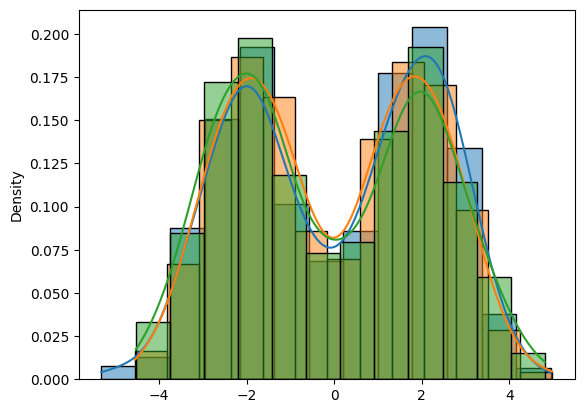

In [4]:
kwargs = {"means": [-2., 2.], "stddevs": [1., 1.], "mixing_coefficients": [0.5, 0.5], "N": 1000}
sns.histplot(sample_gmm_1d(**kwargs).squeeze(1), stat="density", kde="True")
sns.histplot(sample_gmm_1d(**kwargs).squeeze(1), stat="density", kde="True")
sns.histplot(sample_gmm_1d(**kwargs).squeeze(1), stat="density", kde="True")
plt.show()

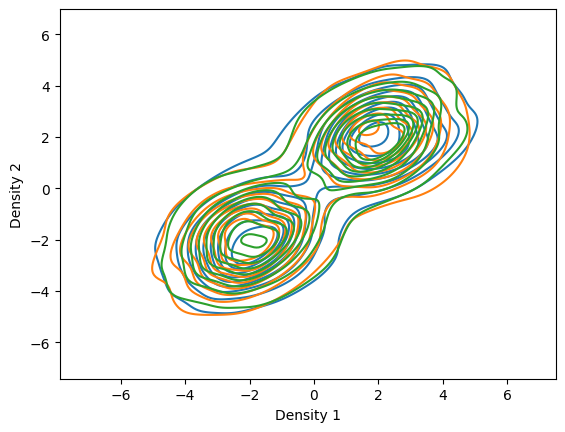

In [5]:
import pandas as pd

kwargs = {"means": [[-2., -2.], [2., 2.]], "scales": [1., 1.], "mixing_coefficients": [0.5, 0.5], "N": 1000}
sns.kdeplot(pd.DataFrame(sample_gmm_2d(**kwargs), columns=["Density 1", "Density 2"]), x="Density 1", y="Density 2")
sns.kdeplot(pd.DataFrame(sample_gmm_2d(**kwargs), columns=["Density 1", "Density 2"]), x="Density 1", y="Density 2")
sns.kdeplot(pd.DataFrame(sample_gmm_2d(**kwargs), columns=["Density 1", "Density 2"]), x="Density 1", y="Density 2")
plt.show()

## Diffusion process

In [6]:
import math
from pathlib import Path
from functools import partial
from collections import namedtuple
from typing import List, Optional, Tuple

import torch
from torch import nn, einsum, Tensor
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from einops import rearrange, reduce, repeat

import numpy as np

from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset


class Custom_Dataset(Dataset):
    def __init__(self, _dataset):
        self.dataset = _dataset

    def __getitem__(self, index):
        example = self.dataset[index]
        return np.array(example)

    def __len__(self):
        return len(self.dataset)


# helpers functions
def exists(x):
    return x is not None


def default(val, d):
    if exists(val):
        return val
    return d() if callable(d) else d


# small helper modules
def Upsample(dim: int, dim_out: Optional[int] = None) -> nn.Module:
    return nn.Sequential(
        nn.Upsample(scale_factor=2, mode="nearest"),
        nn.Conv1d(dim, default(dim_out, dim), 3, padding=1)
    )


def Downsample(dim: int, dim_out: Optional[int] = None) -> nn.Module:
    return nn.Conv1d(dim, default(dim_out, dim), 4, 2, 1)


# sinusoidal positional embeds
class SinusoidalPosEmb(nn.Module):
    
    def __init__(self, dim: int, theta: int = 10000):
        super().__init__()
        self.dim = dim
        self.theta = theta

    def forward(self, x: torch.FloatTensor) -> torch.FloatTensor:
        device = x.device
        half_dim = self.dim // 2
        emb = math.log(self.theta) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = x[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb


# building block modules
class Block(nn.Module):
    
    def __init__(self, dim: int, dim_out: int, groups: int = 8):
        super().__init__()
        self.proj = nn.Conv1d(dim, dim_out, 3, padding=1)
        self.norm = nn.GroupNorm(groups, dim_out)
        self.act = nn.SiLU()

    def forward(
        self,
        x: torch.FloatTensor,
        scale_shift: Optional[Tuple[torch.FloatTensor, torch.FloatTensor]] = None,
    ) -> torch.FloatTensor:
        x = self.proj(x)
        x = self.norm(x)

        if exists(scale_shift):
            scale, shift = scale_shift
            x = x * (scale + 1) + shift

        x = self.act(x)
        return x


class ResnetBlock(nn.Module):
    def __init__(self, dim: int, dim_out: int, time_emb_dim: Optional[int] = None, groups: int = 8):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.SiLU(),
            nn.Linear(time_emb_dim, dim_out * 2)
        ) if exists(time_emb_dim) else None
        self.block1 = Block(dim, dim_out, groups = groups)
        self.block2 = Block(dim_out, dim_out, groups = groups)
        self.res_conv = nn.Conv1d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x: torch.FloatTensor, time_emb: torch.FloatTensor = None) -> torch.FloatTensor:
        scale_shift = None
        if exists(self.mlp) and exists(time_emb):
            time_emb = self.mlp(time_emb)
            time_emb = rearrange(time_emb, "b c -> b c 1")
            scale_shift = time_emb.chunk(2, dim = 1)
            
        h = self.block1(x, scale_shift=scale_shift)
        h = self.block2(h)
        h = h + self.res_conv(x)
        return h


class Unet1d(nn.Module):
    
    def __init__(
        self,
        dim: int,
        dim_mults: List[int] = [1, 2, 4, 8],
        channels: int = 1,
        resnet_block_groups: int = 8,
        learned_sinusoidal_dim: int = 16,
        sinusoidal_pos_emb_theta: int = 10000,
    ):
        super().__init__()

        # determine dimensions
        dims = [dim, *map(lambda m: dim * m, dim_mults)]
        in_out = list(zip(dims[:-1], dims[1:]))
        out_dim = channels
        mid_dim = dims[-1]
        num_resolutions = len(in_out)
        
        # time embeddings
        time_dim = dim * 4
        sinu_pos_emb = SinusoidalPosEmb(dim, theta=sinusoidal_pos_emb_theta)
        fourier_dim = dim
        self.time_mlp = nn.Sequential(
            sinu_pos_emb,
            nn.Linear(fourier_dim, time_dim),
            nn.GELU(),
            nn.Linear(time_dim, time_dim)
        )

        # layers
        block_klass = partial(ResnetBlock, groups=resnet_block_groups)
        
        self.init_conv = nn.Conv1d(channels, dim, 7, padding=3)
        
        self.downs = nn.ModuleList([])
        self.ups = nn.ModuleList([])

        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (num_resolutions - 1)
            self.downs.append(nn.ModuleList([
                block_klass(dim_in, dim_in, time_emb_dim = time_dim),
                Downsample(dim_in, dim_out) if not is_last else nn.Conv1d(dim_in, dim_out, 3, padding=1)
            ]))

        self.mid_block = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)

        for ind, (dim_in, dim_out) in enumerate(reversed(in_out)):
            is_last = ind == (len(in_out) - 1)
            self.ups.append(nn.ModuleList([
                block_klass(dim_out + dim_in, dim_out, time_emb_dim = time_dim),
                Upsample(dim_out, dim_in) if not is_last else nn.Conv1d(dim_out, dim_in, 3, padding=1)
            ]))

        self.final_res_block = block_klass(dim * 2, dim, time_emb_dim=time_dim)
        self.final_conv = nn.Conv1d(dim, out_dim, 1)

    def forward(self, x, time):
        x = self.init_conv(x)
        r = x.clone()

        t = self.time_mlp(time)

        h = []
        for block1, downsample in self.downs:
            x = block1(x, t)
            h.append(x)
            x = downsample(x)

        x = self.mid_block(x, t)

        for block1, upsample in self.ups:
            x = torch.cat((x, h.pop()), dim=1)
            x = block1(x, t)
            x = upsample(x)

        x = torch.cat((x, r), dim = 1)
        x = self.final_res_block(x, t)
        x = self.final_conv(x)

        return x

In [7]:
# import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from tqdm.auto import tqdm


class StableDiffusion1d:
    
    def __init__(self, unet: Unet1d, time_steps: int, sample_steps: int):
        self.unet = unet
        self.device = next(unet.parameters()).device
        
        self.time_steps = time_steps
        # sample_steps < time_steps
        self.sample_steps = sample_steps
        self.tau = torch.linspace(self.time_steps - 1, 0, (self.sample_steps + 1)).long().to(self.device)
        self.betas = self._linear_beta_schedule().to(self.device)

        self.alphas = 1. - self.betas
        self.alphas_bar = torch.cumprod(self.alphas, axis=0)
        self.alphas_bar_prev = F.pad(self.alphas_bar[:-1], (1, 0), value=1.0)
        self.sqrt_recip_alphas = torch.sqrt(1.0 / self.alphas)
        self.sqrt_recip_alphas_prev = F.pad(self.sqrt_recip_alphas[:-1], (1, 0), value=1.0)
        self.sqrt_alphas_bar = torch.sqrt(self.alphas_bar)
        self.sqrt_alphas_bar_prev = F.pad(self.sqrt_alphas_bar[:-1], (1, 0), value=1.0)
        self.sqrt_minus_alphas_bar = torch.sqrt(1. - self.alphas_bar)
        self.sqrt_minus_alphas_bar_prev = F.pad(self.sqrt_minus_alphas_bar[:-1], (1, 0), value=1.0)
        self.posterior_variance = self.betas * (1. - self.alphas_bar_prev) / (1. - self.alphas_bar)
    
    def _get_index_from_list(self, vals: torch.Tensor, t: torch.Tensor, x_shape: torch.Size) -> torch.Tensor:
        """ helper function to get index from list, considering batch dimension
        
        Args:
            vals (torch.Tensor): list of values
            t (torch.Tensor): timestep
            x_shape (torch.Size): shape of input image

        Returns:
            torch.Tensor: value at timestep t
        """
        batch_size = t.shape[0] # batch_size
        out = vals.gather(-1, t) # (batch_size, 1)
        return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)
    
    def _linear_beta_schedule(self, start=0.0001, end=0.02) -> torch.Tensor:
        """ linear beta schedule
        Args:
            start (float, optional): beta at timestep 0. Defaults to 0.0001.
            end (float, optional): beta at last timestep. Defaults to 0.02.

        Returns:
            torch.Tensor: beta schedule
        """
        return torch.linspace(start, end, self.time_steps)
    
    def forward(self, x_0: torch.Tensor, t: torch.Tensor, type='forecast'):
        """ forward process of diffusion model
        Args:
            x_0 (torch.Tensor): input image
            t (torch.Tensor): timestep
            
        Returns:
            tuple[torch.Tensor, torch.Tensor]: noisy image and noise
        """
        noise = torch.randn_like(x_0).to(self.device)
        
        sqrt_alphas_cumprod_t = self._get_index_from_list(
            self.sqrt_alphas_bar, t, x_0.shape
        )
        sqrt_one_minus_alphas_cumprod_t = self._get_index_from_list(
            self.sqrt_minus_alphas_bar, t, x_0.shape
        )
        # mean + variance
        return sqrt_alphas_cumprod_t.to(self.device) * x_0.to(self.device) \
            + sqrt_one_minus_alphas_cumprod_t.to(self.device) * noise.to(self.device), \
            noise.to(self.device)
            
    @torch.no_grad()
    def sample_timestep(self, x: torch.Tensor, t: torch.Tensor, obs=None) -> torch.Tensor:
        """
        Calls the model to predict the noise in the image and returns 
        the denoised image. 
        Applies noise to this image, if we are not in the last step yet.
        """
        betas_t = self._get_index_from_list(self.betas, t, x.shape)
        sqrt_one_minus_alphas_cumprod_t = self._get_index_from_list(
            self.sqrt_minus_alphas_bar, t, x.shape
        )
        sqrt_recip_alphas_t = self._get_index_from_list(self.sqrt_recip_alphas, t, x.shape)
        
        text_e = None
        if obs is not None:
            text_f = self.clip_model.text_encoder(obs)
            text_e = self.clip_model.text_projection(text_f)
        
        # Call model (current image - noise prediction)
        model_mean = sqrt_recip_alphas_t * (
            x - betas_t * self.unet(x, t) / sqrt_one_minus_alphas_cumprod_t
        )
        posterior_variance_t = self._get_index_from_list(self.posterior_variance, t, x.shape)
        
        if t == 0:
            # As pointed out by Luis Pereira (see YouTube comment)
            # The t's are offset from the t's in the paper
            return model_mean
        else:
            noise = torch.randn_like(x)
            return model_mean + torch.sqrt(posterior_variance_t) * noise
        
    @torch.no_grad()
    def sampling(self, x_T: torch.Tensor, obs=None) -> torch.Tensor:
        """ sampling process of diffusion model
        Args:
            x_T (torch.Tensor): input image (gaussian noise)
            
        Returns:
            torch.Tensor: denoised image
        """
        x = x_T
        for i in tqdm(reversed(range(self.time_steps)), desc="Sampling"):
            t = torch.full((x.shape[0],), i, dtype=torch.long, device=self.device)
            x = self.sample_timestep(x, t, obs)
        return x
    
    @torch.no_grad()
    def sampling_sequence(self, x_shape: torch.Size, obs=None) -> np.ndarray:
        x_T = torch.randn(x_shape).to(self.device)
        sampled_tensor = self.sampling(x_T, obs)
        return sampled_tensor
    
    @torch.no_grad()
    def sampling_guided(self, x_T: torch.Tensor, x_f, y_o, s_f, s_o) -> torch.Tensor:
        """ sampling process of diffusion model
        Args:
            x_T (torch.Tensor): input image (gaussian noise)
            
        Returns:
            torch.Tensor: denoised image
        """
        x = x_T
        eta = 1
        for i in tqdm(range(1, self.sample_steps + 1), desc='DDIM Sampling'):
            itau = torch.full((x.shape[0],), i, dtype=torch.long, device=self.device)
            x = self.sample_timestep_guidance(x_f, y_o, s_f, s_o, x, itau)
        return x

/vol/biomedic3/rrr2417/.cache/pypoetry/virtualenvs/cxr-generation-5nFhYdiM-py3.9/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
# https://github.com/lantel-wm/1d_ddpm/blob/main/ddpm/diffusion1d.py

class Trainer:
    
    def __init__(
        self,
        diffuser: StableDiffusion1d,
        batch_size: int, 
        epochs: int, 
    ) -> None:    
        self.batch_size = batch_size
        self.diffuser = diffuser
        self.T = self.diffuser.time_steps
        self.forward_diffusion_sample = self.diffuser.forward
        self.unet = self.diffuser.unet
        self.device = next(self.unet.parameters()).device
        self.sampler = self.diffuser.sampling_sequence
        self.model_save_dir = "results"
        self.optimizer = torch.optim.Adam(self.unet.parameters(), lr=1e-5)
        self.epochs = epochs
    
    def get_loss(self, x_0, t):
        x_noisy, noise = self.forward_diffusion_sample(x_0, t)
        noise_pred = self.unet(x_noisy, t)
        return F.l1_loss(noise, noise_pred)
    
    def save_model_weight(self, epoch):
        torch.save(self.unet.state_dict(), f'{self.model_save_dir}/model_{epoch}.pt')
        
    def save_sampled_image(self, epoch, x_shape: torch.Size):
        sampled_img = self.sampler(x_shape, 'image')
        cv2.imwrite(f"{self.model_save_dir}/sampled_{epoch}.jpg", sampled_img)
        
    def save_sampled_sequence(self, epoch, x_shape: torch.Size, obs = None):
        sampled_seq = self.sampler(x_shape)
        sampled_seq = sampled_seq.squeeze().detach().cpu().numpy()
        plt.plot(sampled_seq)
        plt.savefig(f"{self.model_save_dir}/sampled_seq_{epoch}.jpg")
        plt.close()
        
    def train(self, dataloader):
        for epoch in range(self.epochs):
            loop = tqdm(dataloader, desc=f"Epoch {epoch}")
            # losses = []
            obs_for_sample = None
            for data in loop:
                self.optimizer.zero_grad()
                # [0, T)
                t = torch.randint(0, self.T, (self.batch_size,)).to(self.device).long()
                data = data.to(self.device)
                loss = self.get_loss(data, t)
                loss.backward()
                self.optimizer.step()
                loop.set_postfix(loss=loss.item(), t=t[0].item())

## 1D Bimodal

In [9]:
unet = Unet1d(
    dim=20,
    resnet_block_groups=5,
    dim_mults=(1,),
    channels=1,
).to(device)
sd = StableDiffusion1d(unet, 100, 10)
trainer = Trainer(
    sd, 1, 100,
)

In [10]:
from tqdm import tqdm

training_data = [sample_gmm_1d([-2, 2], [1, 1], [0.5, 0.5], 1000).unsqueeze(0) for _ in tqdm(range(1000))]
training_data = torch.cat(training_data).transpose(2, 1)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:10<00:00, 14.23it/s]


In [11]:
train_loader = DataLoader(
    dataset=Custom_Dataset(training_data),
    batch_size=32,
    shuffle=False,
)
trainer.train(train_loader)

Epoch 99: 100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 49.46it/s, loss=0.661, t=92]


Sampling: 100it [00:00, 293.16it/s]


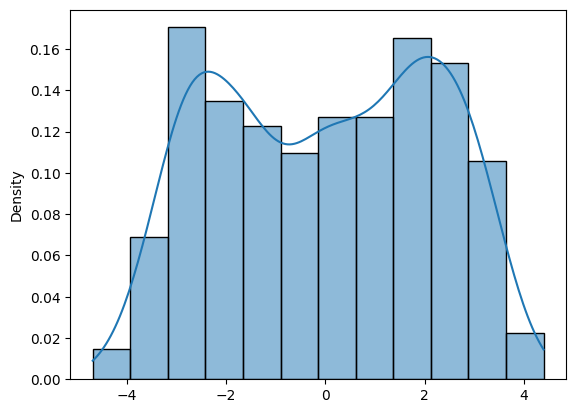

In [12]:
x_noisy, _ = trainer.forward_diffusion_sample(training_data[0].unsqueeze(0).to(device), torch.tensor((99,)).to(device))
sns.histplot(sd.sampling(x_noisy).cpu().squeeze(0).squeeze(0).numpy(), stat="density", kde="True")
plt.show()

## 2D Bimodal

In [13]:
unet = Unet1d(
    dim=20,
    resnet_block_groups=5,
    dim_mults=(1,),
    channels=2,
).to(device)
diffuser = StableDiffusion1d(unet, 100, 10)
trainer = Trainer(
    diffuser, 1, 100,
)

In [14]:
from tqdm import tqdm

kwargs = {"means": [[-2., -2.], [2., 2.]], "scales": [1., 1.], "mixing_coefficients": [0.5, 0.5], "N": 1000}
training_data_2d = [sample_gmm_2d(**kwargs).unsqueeze(0).transpose(1, 2) for _ in tqdm(range(100))]
training_data_2d = torch.cat(training_data_2d)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 12.19it/s]


In [15]:
train_loader = DataLoader(
    dataset=Custom_Dataset(training_data_2d),
    batch_size=32,
    shuffle=False,
)
trainer.train(train_loader)

Epoch 99: 100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 42.40it/s, loss=0.775, t=68]


Sampling: 100it [00:00, 415.74it/s]


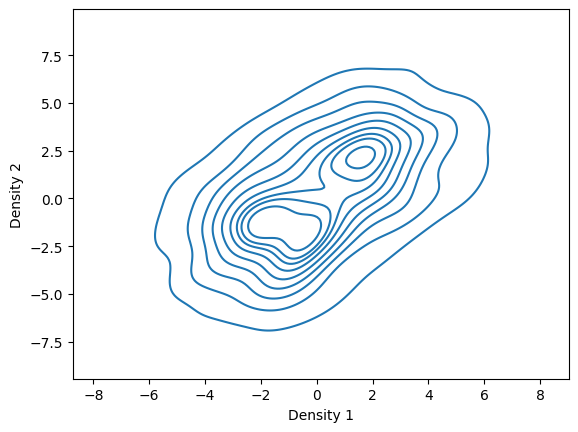

In [16]:
x_noisy, _ = trainer.forward_diffusion_sample(training_data_2d[0].unsqueeze(0).to(device), torch.tensor((99,)).to(device))
kwargs = {"means": [[-2., -2.], [2., 2.]], "scales": [1., 1.], "mixing_coefficients": [0.5, 0.5], "N": 1000}
sns.kdeplot(pd.DataFrame(diffuser.sampling(x_noisy).squeeze(0).transpose(0, 1).cpu(), columns=["Density 1", "Density 2"]), x="Density 1", y="Density 2")
plt.show()

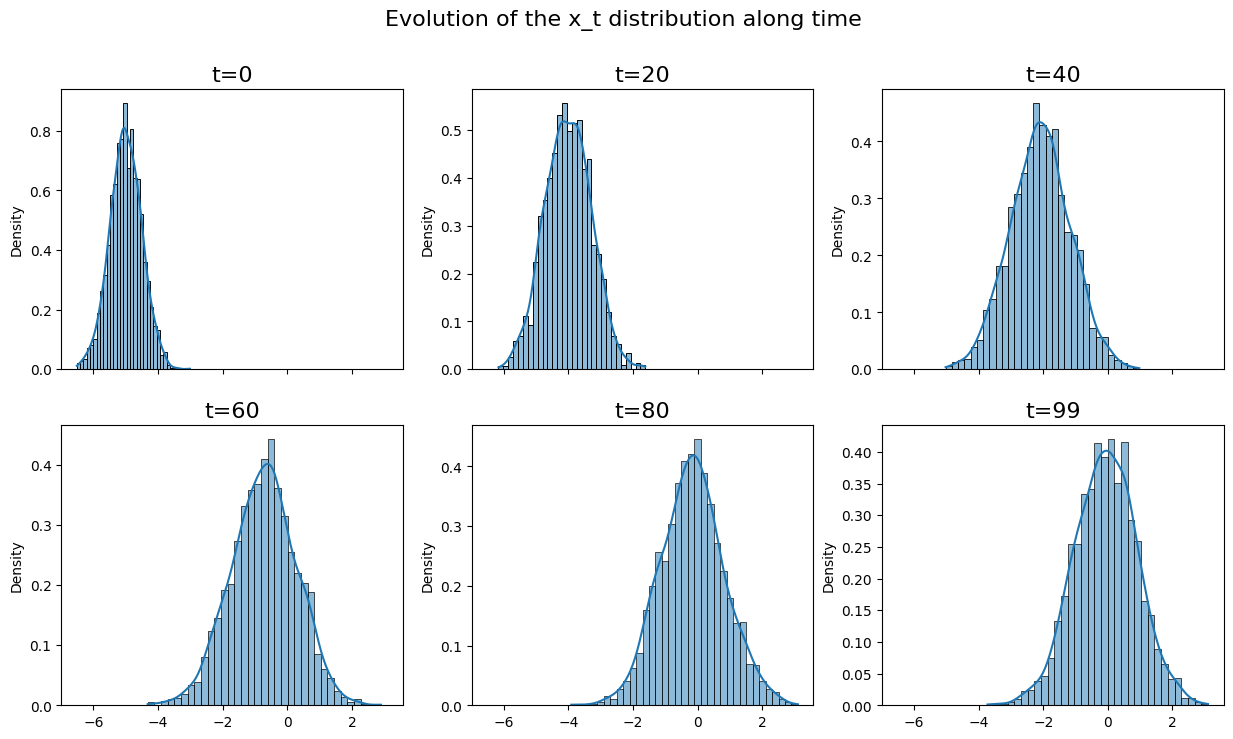

In [35]:
fig, axes = plt.subplots(2, 3, sharex=True, figsize=(15,8))
fig.suptitle('Evolution of the x_t distribution along time', fontsize=16)
for t, ax in zip([0, 20, 40, 60, 80, 99], axes.flatten()):
    sns.histplot(diffuser.forward_process(x0, t)[1].cpu(), stat="density", kde="True", ax=ax)
    ax.set_title(f"t={t}", fontsize=16)
plt.show()

We can also plot some trajectories for some numbers of points of the distribution $p(x_0)$.  We'll see that starting from our arbitrary distribution $p(x_0)$ the trajectories converge to some point symmetric with respect to $0$, exactly as the points distributed as a $\mathcal{N}(0,1)$.

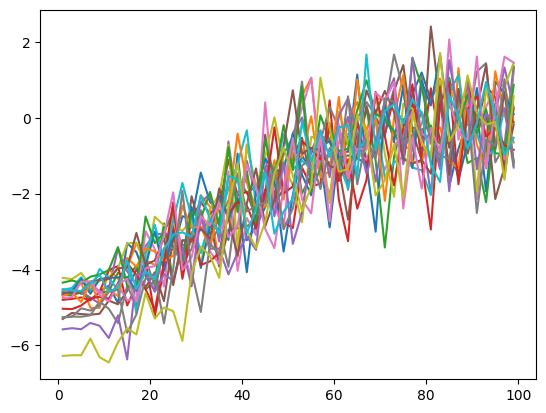

In [36]:
indts = [rd.randrange(0, len_data - 1) for j in range(20)]
xx0 = []
tt = range(1, training_T, 2)
xx0.append(x0[indts].cpu().detach().numpy())
for t in tt:
    xx0.append(diffuser.forward_process(x0[indts], t)[1].cpu().detach().numpy())
plt.plot(tt, xx0[:len(tt)])
plt.show()

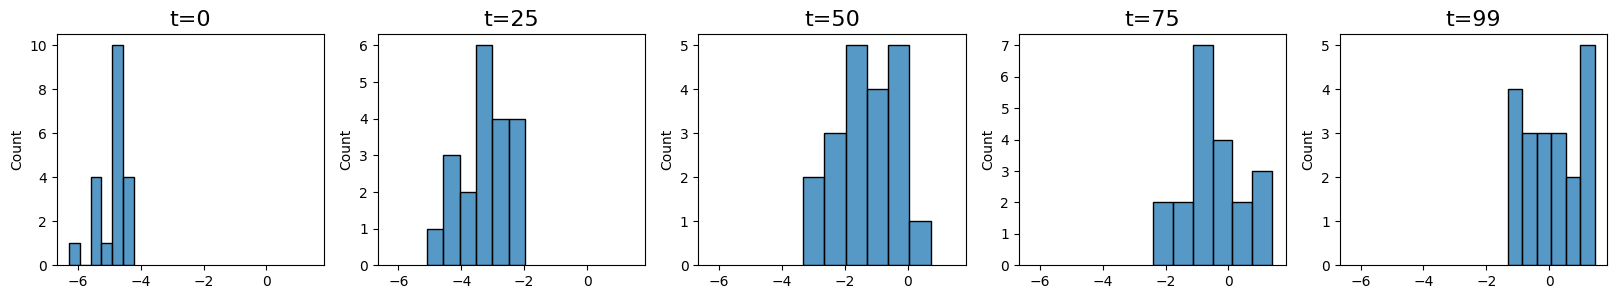

In [37]:
fig, axes = plt.subplots(1, 5, sharex=True, figsize=(20, 3))
for i, t in enumerate([0, 25, 50, 75, 99]):
    sns.histplot(xx0[t // 2], stat="count", ax=axes[i])
    axes[i].set_title(f"t={t}", fontsize=16)
plt.show()

We define now the parameters used for the training

In [38]:
times_used_per_epoch = 400
num_epochs = 20
optimizer = optim.AdamW(denoiser.parameters())

Training

In [39]:
pbar = tqdm(range(num_epochs))

for epoch in pbar: 
    running_loss = 0.0
    times = np.random.randint(1, training_T, times_used_per_epoch)
    for _, t in enumerate(times):
        optimizer.zero_grad()
        loss = diffuser.loss(x0, t)
        loss.backward()
        optimizer.step()
        running_loss += loss.detach()
    pbar.set_description('Epoch: {} Loss: {}'.format(epoch, running_loss / times_used_per_epoch))
print('Finished Training')

Epoch: 19 Loss: 1.003338098526001: 100%|███████████████████████████████████████████████████████████████████████████| 20/20 [00:21<00:00,  1.06s/it]

Finished Training


## Reverse "denoising" process

Let us define here the reverse process as $x_{t-1}=\mu_{\theta}(x_t)+\sqrt{\beta_t} z_t$, i.e. $x_{t-1}$ is generated from a $\mathcal{N}(\mu_{\theta}(x_t), \beta_t I)$.

Now, we simulate this reverse process and plot the distributions going backward in time and some trajectories.

In [40]:
rev = []
rev.append(torch.distributions.MultivariateNormal(torch.zeros(len_data), torch.eye(len_data)).sample().to(device))
for t in tqdm(range(training_T)):
    rev.append(diffuser.reverse_step(rev[t], training_T - t - 1).detach())

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2419.81it/s]


/vol/biomedic3/rrr2417/.cache/pypoetry/virtualenvs/cxr-generation-5nFhYdiM-py3.9/lib/python3.9/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


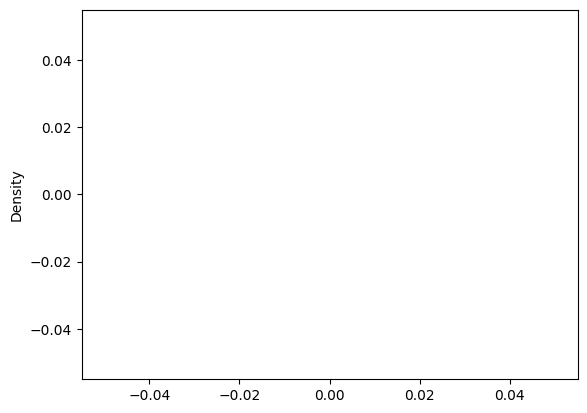

In [41]:
sns.histplot(rev[99].cpu(), stat="density", kde="True")
plt.show()

/vol/biomedic3/rrr2417/.cache/pypoetry/virtualenvs/cxr-generation-5nFhYdiM-py3.9/lib/python3.9/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/vol/biomedic3/rrr2417/.cache/pypoetry/virtualenvs/cxr-generation-5nFhYdiM-py3.9/lib/python3.9/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/vol/biomedic3/rrr2417/.cache/pypoetry/virtualenvs/cxr-generation-5nFhYdiM-py3.9/lib/python3.9/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/vol/biomedic3/rrr2417/.cache/pypoetry/virtualenvs/cxr-generation-5nFhYdiM-py3.9/lib/python3.9/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


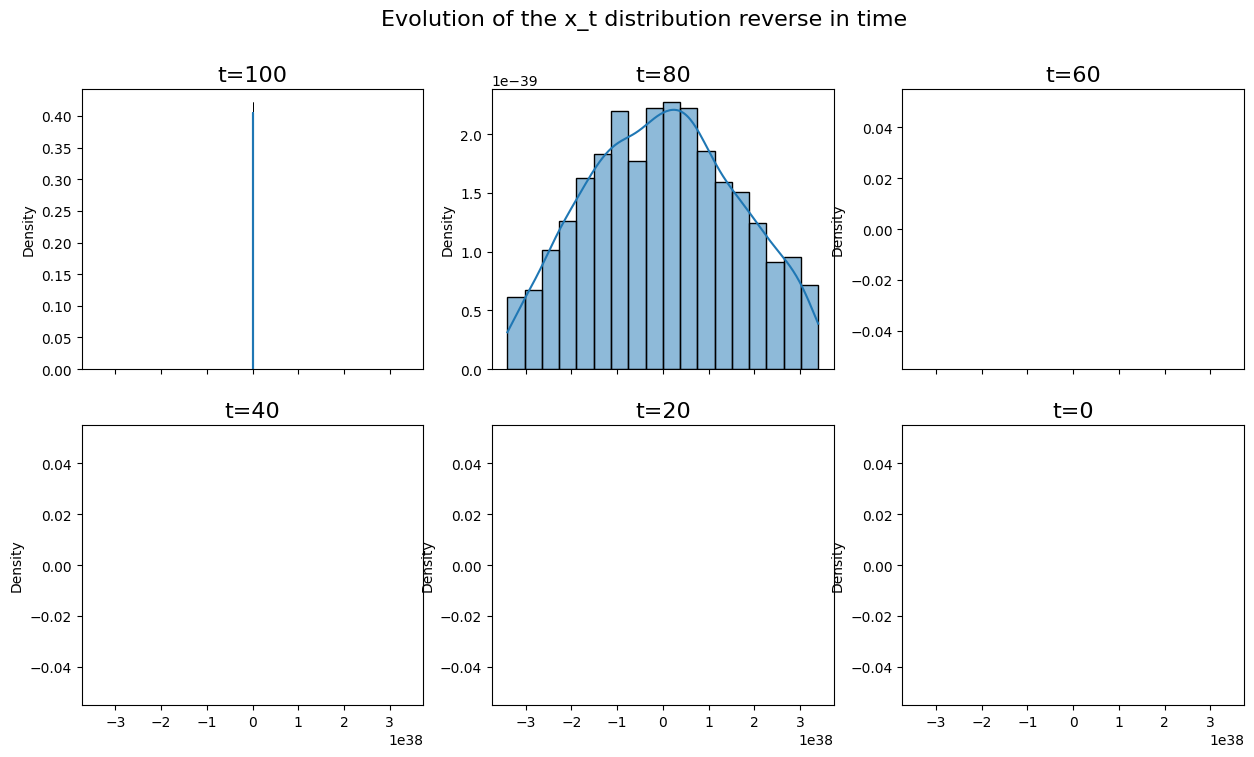

In [42]:
fig, axes = plt.subplots(2, 3, sharex=True, figsize=(15,8))
fig.suptitle('Evolution of the x_t distribution reverse in time', fontsize=16)
sns.histplot(rev[0].cpu(), stat="density", kde="True", ax=axes[0][0])
axes[0][0].set_title('t=100',fontsize=16)
sns.histplot(rev[20].cpu(), stat="density", kde="True", ax=axes[0][1])
axes[0][1].set_title('t=80', fontsize=16)
sns.histplot(rev[40].cpu(), stat="density", kde="True", ax=axes[0][2])
axes[0][2].set_title('t=60', fontsize=16)
sns.histplot(rev[60].cpu(), stat="density", kde="True", ax=axes[1][0])
axes[1][0].set_title('t=40', fontsize=16)
sns.histplot(rev[80].cpu(), stat="density", kde="True", ax=axes[1][1])
axes[1][1].set_title('t=20', fontsize=16)
sns.histplot(rev[99].cpu(), stat="density", kde="True", ax=axes[1][2])
axes[1][2].set_title('t=0', fontsize=16)
plt.show()

We plot some back trajectories starting from 20 random points taken from a dsitribution $\mathcal{N}(0,1)$. It is someway evident that the process "choice" in some way in the first steps where it is heading.

/tmp/ipykernel_1265138/3793272334.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes.set_xticklabels(a)


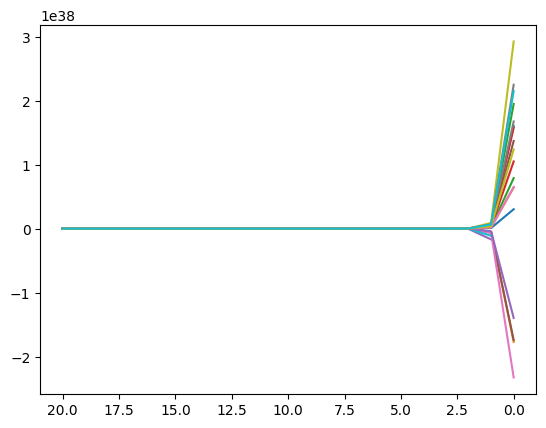

In [151]:
from pylab import *

indts2 = [rd.randrange(0, len_data-1) for j in range(20)]
tt2 = range(training_T)
label = []
back = [[] for _ in range(training_T)]
for j in range(20):
    for t in range(training_T):
        back[t].append(rev[t][indts2[j]].cpu())
        label.append(str(training_T-t))

axes = figure().add_subplot(111)
axes.plot(tt2,back)
a = axes.get_xticks().tolist()
a = a[::-1]
axes.set_xticklabels(a)
plt.show()

## Conditional densities

In this section we evaluate the conditional densities $p(x_{t-1}|x_t)$ using the $\mu_{\theta}$ that our model gave us, i.e. $\mathcal{N}(\mu_{\theta}(x_t), \beta_t I)$, and values of $x_t, x_{t-1}$ in the interval $[-1,1]$.

In [86]:
def cond_dens(model_used, x_tminus1, x_t, t, betas):    #analytical density function for a normal of the form that we found
    sqrtbeta_t = torch.sqrt(betas[t])
    mu_theta_t = model_used(x_t,t)
    A = (sqrt(2 * np.pi) * sqrtbeta_t) ** -1
    B= -0.5 * ((x_tminus1 - x_t) / sqrtbeta_t) ** 2
    f = A * torch.exp(B)
    return f

In [87]:
ax_xt = torch.tensor(np.linspace(-1, 1, len_data)).to(torch.float32).to(device)

prob_dens = [[] for _ in range(T)]
for tx in tqdm(range(T)):
    for x_tminus1 in ax_xt:
        prob_dens[tx].append(cond_dens(model, x_tminus1 ,ax_xt , torch.tensor(tx).to(device), betas).cpu().detach().numpy())

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:03<00:00,  1.58it/s]


In [88]:
list_prob = []
for tx in tqdm(range(T)):
    list_prob.append(np.array([l.tolist() for l in prob_dens[tx]]))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:27<00:00,  3.68it/s]


In [89]:
ixti=ax_xt.cpu().detach().numpy()
list_prob[1].shape

(2000, 2000)

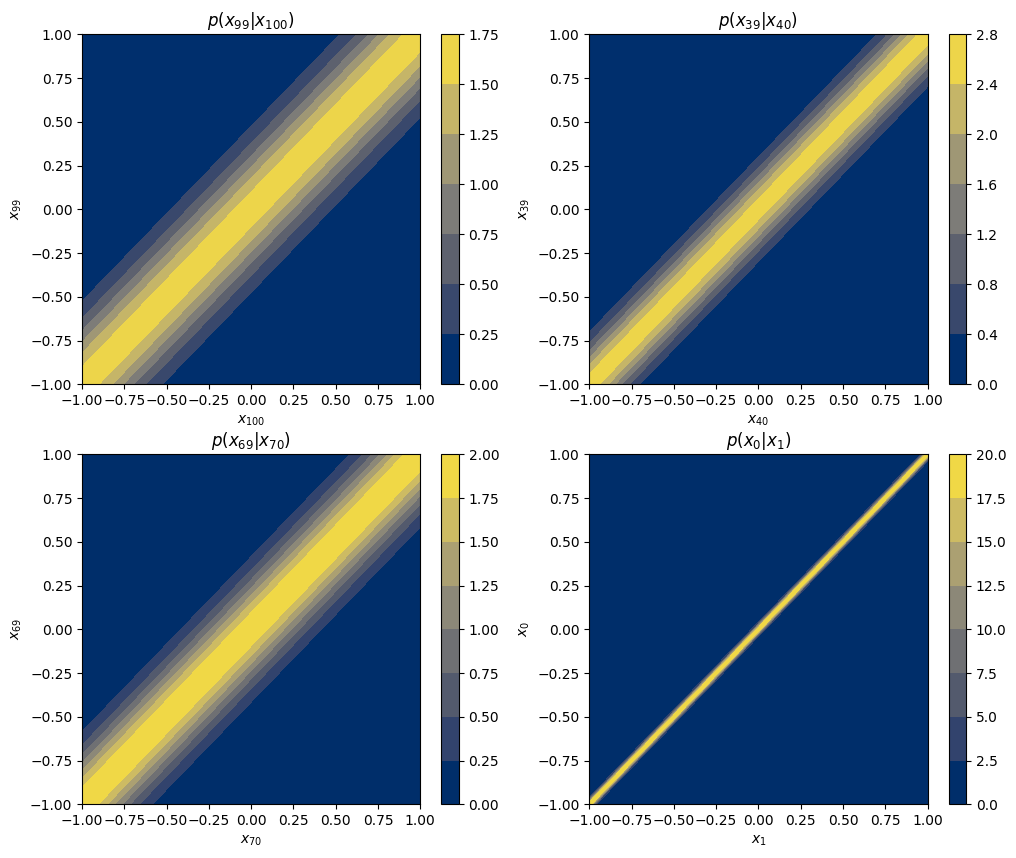

In [90]:
X, Y = meshgrid(ixti,ixti)
fig, axs = plt.subplots(2, 2, figsize=(12,10))
ttt=[99, 69, 39, 0]
i=0
for col in range(2):
    for row in range(2):
        ax = axs[row, col]
        pcm = ax.contourf(X,Y,list_prob[ttt[i]], cmap='cividis')
        ax.set(xlabel='$x_{}$'.format('{'+str(ttt[i]+1)+'}'), ylabel='$x_{}$'.format('{'+str(ttt[i])+'}'), title='$p(x_{}|x_{})$'.format('{'+str(ttt[i])+'}','{'+str(ttt[i]+1)+'}' ))
        fig.colorbar(pcm, ax=ax)
        i=i+1



# Frequences and joint probabilities

In this section we analyze the empirical distributions of the form $p(x_{t'}, x_t)$ obtained with the trajectories that we estimated.

In [34]:
print(max(rev[0]), min(rev[0]))

tensor(3.5552, device='cuda:0') tensor(-3.3729, device='cuda:0')


In [35]:
quant=40
xx0=linspace(-5.5,5.5,quant)     #discretizing the interval in which the x_t s take values 

XX, YY = meshgrid(xx0,xx0)


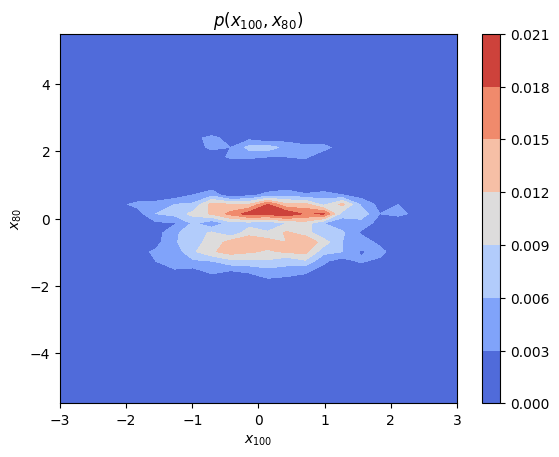

In [36]:
tempo2=80           #t'
tempo1=100           #t

rev_t1=T-tempo1    
rev_t2=T-tempo2
aa=rev[rev_t1].cpu().detach().numpy() 
bb=rev[rev_t2].cpu().detach().numpy()
freq=np.zeros((quant,quant))      

for i in range(len(aa)):
    j=0
    jb=0
    while aa[i]>xx0[j]:
        if j>quant-2:
            break
        j=j+1
    while bb[i]>xx0[jb]:
        if jb>quant-2:
            break
        jb=jb+1
    freq[jb][j]=freq[jb][j]+1


fig = plt.figure()
ax = fig.add_subplot(111)

surf = ax.contourf(XX, YY, freq/sum(freq), cmap=cm.coolwarm,)
ax.set_xlim(-3, 3)
ax.set(xlabel='$x_{}$'.format('{'+str(tempo1)+'}'), ylabel='$x_{}$'.format('{'+str(tempo2)+'}'), title='$p(x_{},x_{})$'.format('{'+str(tempo1)+'}','{'+str(tempo2)+'}'))
fig.colorbar(surf)

plt.show()

Below we create a video with the plots that we obtained fxing $t=100$ and varying $t'$ from $99$ to $0$. It is possible to see how the final distribution appears.

FileNotFoundError: [Errno 2] No such file or directory: './plotsLast/1.png'

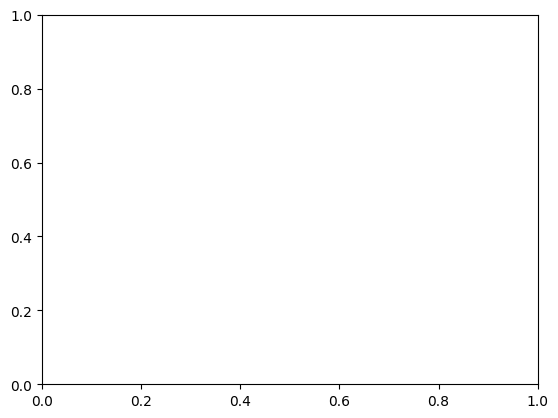

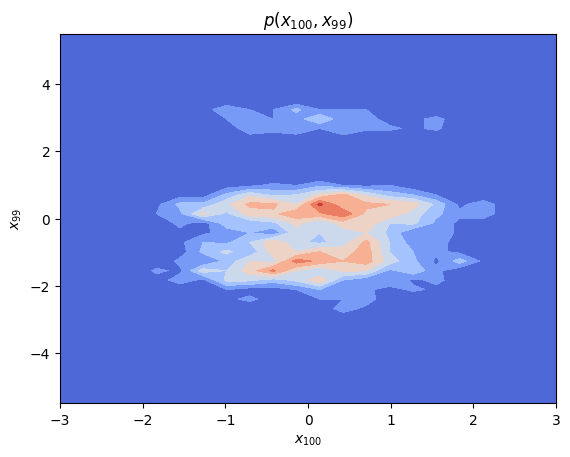

In [37]:
tempo1=T
rev_t1=T-tempo1
aa=rev[rev_t1].cpu().detach().numpy()

quant=40
xx0=linspace(-5.5,5.5,quant)     #discretizing the interval in which the x_t s take values 
XX, YY = meshgrid(xx0,xx0)


fig, ax = plt.subplots()
 
for t in range(1,T):
     
    # clear
    freq=np.zeros((quant,quant))
    
    tempo2=t
    #frequencies tab
    rev_t2=T-t
    bbt=rev[tempo2].cpu().detach().numpy()
    for i in range(len(aa)):
        j=0
        jb=0
        while aa[i]>xx0[j]:
            if j>quant-2:
                break
            j=j+1
        while bbt[i]>xx0[jb]:
            if jb>quant-2:
                break
            jb=jb+1
        freq[jb][j]=freq[jb][j]+1

#    ax.clear()
    fig = plt.figure()
    ax = fig.add_subplot(111)
    surf=ax.contourf(XX, YY, freq/sum(freq), cmap=cm.coolwarm,)
    ax.set_xlim(-3, 3)
    ax.set(xlabel='$x_{}$'.format('{'+str(tempo1)+'}'), ylabel='$x_{}$'.format('{'+str(rev_t2)+'}'), title='$p(x_{},x_{})$'.format('{'+str(tempo1)+'}','{'+str(rev_t2)+'}'))
    #fig.colorbar(surf)
    # returning numpy image
    fig.savefig('./plotsLast/{}.png'.format(t))
    plt.close(fig)

#animation = VideoClip(make_frame, duration = duration)

#animation.ipython_display(fps = 2, loop = True, autoplay = True)

In [ ]:
import os
import glob
from natsort import natsorted
from moviepy.editor import *


gif_name = 'pic'
fps = 24

file_list = glob.glob('./plotsLast/*.png')  # Get all the pngs in the current directory
file_list_sorted = natsorted(file_list,reverse=False)  # Sort the images

clips = [ImageClip(m).set_duration(0.25)
         for m in file_list_sorted]

len(file_list_sorted)
concat_clip = concatenate_videoclips(clips, method="chain")
concat_clip.write_videofile("LastVideo.mp4", fps=fps)

Uncomment the following lines to see the video directly in the notebook

In [ ]:
#from IPython.display import Video

#Video("LastVideo.mp4")

## GMM - Gaussian Mixture Model

In this section we model the joint probability distribution $p(x_0, x_{100})$ as a combination of Gaussian random distributions.

In [ ]:
from sklearn import mixture
x100=rev[0].cpu().detach().numpy()
x0=rev[len(rev)-1].cpu().detach().numpy()

X=np.array([x100,x0]).T

In [ ]:
GMM = mixture.GaussianMixture(n_components=3, covariance_type='full')
gmm = GMM.fit(X)
labels = gmm.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=10, cmap='viridis')
plt.xlabel("x100")
plt.ylabel("x0")

Below we generate new sample from the distribution taht we just estimated and see if they fits, at least graphically, the distribution found with the previous simulations.

In [ ]:
data_new = gmm.sample(1000)
#sns.histplot(data_new[0], stat="density", kde="True")    #plot the distribution
generated=data_new[0]

generatedx0=[]
X_gen=[]
for i in enumerate(generated):
    generatedx0.append(i[1][1])
    X_gen.append(i[1][0])

In [ ]:
sns.histplot(generatedx0, stat="density", kde="True")

In [ ]:
plt.scatter(X_gen, generatedx0, s=10)
plt.xlabel("x100 generated by GMM")
plt.ylabel("x0 generated by GMM")

### Below we use the same approach to model $p(x_{100}-x_0,x_0)$.

Now, we do the same thing, considering $x_0$ depending on $x_{100}-x_0$

In [ ]:
XX=np.array([x100-x0,x0]).T

GMM2 = mixture.GaussianMixture(n_components=3, covariance_type='full')
gmm2 = GMM2.fit(XX)
labels = gmm2.predict(XX)
plt.scatter(XX[:, 0], XX[:, 1], c=labels, s=10, cmap='viridis')
plt.xlabel("x100-x0")
plt.ylabel("x0")

In [ ]:
data_new2 = gmm2.sample(1000)
#sns.histplot(data_new[0], stat="density", kde="True")    #plot the distribution
generated2=data_new2[0]

generatedx02=[]
X_gen2=[]
for i in enumerate(generated2):
    generatedx02.append(i[1][1])
    X_gen2.append(i[1][0])

In [ ]:
sns.histplot(generatedx02, stat="density", kde="True")

In [ ]:
plt.scatter(X_gen2, generatedx02, s=10)
plt.xlabel("x100-x0 generated by GMM")
plt.ylabel("x0 generated by GMM")

### Without reverse diffusion process

In 1-dimension, being the data and the initial distribution much simpler than real images, it is possible to generate new elements of the initial distribution simply generating a GMM fitting all the $x_0$ passed to the model and then sampling elements from this model. In the literature, for example in https://arxiv.org/pdf/2104.12686.pdf is pointed out that it is not a doable approach to images generation due to the great amount of gaussian components that would be necessary to model such distributions.

In [ ]:
xorig=x0

In [ ]:
xfor=p_forward(x_0, 99, list_bar_alphas, device).cpu().detach().numpy()

In [ ]:
Xp=np.array([xfor,xorig]).T
print(Xp[:4])

plt.scatter(Xp[:,0], Xp[:,1], s=10)
plt.xlabel("x100")
plt.ylabel("x0 data")

In [ ]:
GMM0 = mixture.GaussianMixture(n_components=3, covariance_type='full')
gmm0 = GMM0.fit(Xp)
data_new0 = gmm0.sample(1000)
generated0=data_new0[0]



generatedx00=[]
X_gen0=[]
for i in enumerate(generated0):
    generatedx00.append(i[1][1])
    X_gen0.append(i[1][0])



In [ ]:
sns.histplot(generatedx00, stat="density", kde="True")